In [154]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import GPy

import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

In [155]:
# data = pd.read_csv('data\data_gp_pm25_10s.csv')
# iaq_type = 'PM2.5'

data =pd.read_csv('data\data_gp_voc_10s.csv')
iaq_type = 'TVOC'

In [156]:
train_horizon = 300
predict_horizon = 600
interval = 5

In [157]:
# Convert the data to a NumPy array
data_array = np.array(data)

# Extract the first three columns
xy = data_array[:, 1:3]
xyt = np.hstack((xy, interval*np.arange(len(data)).reshape(-1, 1)))
Y = data_array[:, 3]


In [158]:
# Get indices for the test set where x < 0 and y < -3
# test_indices = np.where((xyt[:, 0] < 0) & (xyt[:, 1] < -3))[0]
# test_indices = np.where((xyt[:, 0] < 0) & (xyt[:, 1] > -3))[0]
# test_indices = np.where((xyt[:, 0] > 0) & (xyt[:, 1] < -3))[0]
test_indices = np.where((xyt[:, 0] > 0) & (xyt[:, 1] > -3))[0]

# Get indices for the training set (remaining indices)
train_indices = np.setdiff1d(np.arange(xyt.shape[0]), test_indices)

# Split xyt into training and test sets
xyt_train = xyt[train_indices]
xyt_test = xyt[test_indices]

# Split Y into training and test sets
Y_train = Y[train_indices]
Y_test = Y[test_indices]

In [159]:
def split_by_area(xyt, Y):
    # Define the conditions for splitting
    conditions = [
        (xyt[:, 0] < 0) & (xyt[:, 1] < -3),
        (xyt[:, 0] < 0) & (xyt[:, 1] > -3),
        (xyt[:, 0] > 0) & (xyt[:, 1] < -3),
        (xyt[:, 0] > 0) & (xyt[:, 1] > -3)
    ]

    # Initialize dictionaries to store the split data
    split_data = {'xyt_train': [], 'Y_train': [], 'xyt_test': [], 'Y_test': []}

    # Split the data based on the conditions
    for condition in conditions:
        indices_train = np.where(~condition)[0]
        indices_test = np.where(condition)[0]
        split_data['xyt_test'].append(xyt[indices_test])
        split_data['Y_test'].append(Y[indices_test])
        split_data['xyt_train'].append(xyt[indices_train])
        split_data['Y_train'].append(Y[indices_train])
    return split_data


In [160]:
split_by_area(xyt, Y)
split_data = split_by_area(xyt, Y)

for i, area in enumerate(split_data['xyt_train']):
    print(f"Area {i+1}:")
    print("Training Data (xyt):")
    print(split_data['xyt_train'][i])
    print("Training Data (Y):")
    print(split_data['Y_train'][i])
    print("Test Data (xyt):")
    print(split_data['xyt_test'][i])
    print("Test Data (Y):")
    print(split_data['Y_test'][i])
    print("\n")

Area 1:
Training Data (xyt):
[[0.0018353108928586 -0.0007685751110847 0]
 [0.0018856297696474 -0.0007481031650822 5]
 [0.0136294962121719 -0.0010881799790982 10]
 [0.5746331677236256 0.0114452398321492 15]
 [1.2950376195562718 0.0234573037834906 20]
 [1.2276557535754709 -0.3086845750871457 25]
 [1.1205740138701628 -1.1243268083809013 30]
 [0.916831475558971 -1.544223312204578 35]
 [0.1861396250095205 -1.5334811777501671 40]
 [-0.699461803670152 -1.6314158562254917 45]
 [-1.5377773934883725 -1.7523143006303723 50]
 [-1.7347559001378878 -2.0474332090847955 55]
 [-1.7611538634069082 -2.8142260873633465 60]
 [-1.3556440499777307 -2.8016627533641274 65]
 [-0.5072615071119766 -2.856175059706437 70]
 [0.356942680045109 -2.917882544056216 75]
 [1.1643859643886063 -2.9877953102375163 80]
 [1.191586729043952 -3.4133598818800484 85]
 [1.2718114277762258 -4.246863833888021 90]
 [0.9325375191897274 -4.321800088547319 95]
 [0.0703680777534953 -4.361077565413255 100]
 [0.4020957098310074 -5.743602078

In [161]:
scaler = StandardScaler().fit(xyt_train)
xyt_scaled = scaler.transform(xyt_train)
xyt_test_scaled = scaler.transform(xyt_test)

In [162]:
def gp_train(xyt, Y):
    # kernel = ConstantKernel() * RBF() + WhiteKernel()
    # model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
    # model.fit(xyt, Y)
    # spatial_kernel = GPy.kern.RBF(input_dim=2, active_dims=[0, 1], lengthscale=1.0, ARD=False, variance=1.0)
    # spatial_kernel = GPy.kern.Matern52(input_dim=2, active_dims=[0, 1], lengthscale=1.0, ARD=True, variance=1.0)
    spatial_kernel = GPy.kern.Matern32(input_dim=2, active_dims=[0, 1], lengthscale=1.0, ARD=True, variance=1.0)
    spatial_kernel.lengthscale.constrain_bounded(1e-6, 1e6)
    # tvoc temporal kernel
    # temporal_kernel = GPy.kern.StdPeriodic(input_dim=1, active_dims=[2], period=4.0, lengthscale=1.0, variance=1.0)
    temporal_kernel = GPy.kern.Exponential(input_dim=1, active_dims=[2], lengthscale=1.0, variance=1.0)
    # pm10 temporal kernel
    # temporal_kernel = GPy.kern.RBF(input_dim=1, active_dims=[2], lengthscale=1.0, variance=1.0)
    # temporal_kernel = GPy.kern.PeriodicExponential(input_dim=1, active_dims=[2], lengthscale=1.0, period=1.0, variance=1.0)
    # temporal_kernel = GPy.kern.Cosine(input_dim=1, active_dims=[2], lengthscale=1e3, variance=1e-5)
    kernel = spatial_kernel * temporal_kernel

    # Instantiate the Gaussian process regression model
    gpr = GPy.models.GPRegression(xyt, Y.reshape(-1,1), kernel=kernel)

    # Fit the model to the training data
    gpr.optimize(messages=True)
    return gpr

In [163]:
# Define the kernel for the Gaussian process
spatial_kernel = GPy.kern.RBF(input_dim=2, active_dims=[0, 1], lengthscale=1.0, ARD=True, variance=1.0)
spatial_kernel = GPy.kern.Matern52(input_dim=2, active_dims=[0, 1], lengthscale=1.0, ARD=True, variance=1.0)
spatial_kernel = GPy.kern.Matern32(input_dim=2, active_dims=[0, 1], lengthscale=1.0, ARD=True, variance=1.0)
# tvoc temporal kernel
temporal_kernel = GPy.kern.StdPeriodic(input_dim=1, active_dims=[2], period=4.0, lengthscale=1.0, variance=1.0)
# pm10 temporal kernel
# temporal_kernel = GPy.kern.RBF(input_dim=1, active_dims=[2], lengthscale=1.0, variance=1.0)
# temporal_kernel = GPy.kern.Matern32(input_dim=1, active_dims=[2], lengthscale=1.0, variance=1.0)
# temporal_kernel = GPy.kern.PeriodicExponential(input_dim=1, active_dims=[2], lengthscale=1.0, variance=1.0, period=6.283185307179586, n_freq=100, lower=0.0, upper=12.566370614359172)
# temporal_kernel = GPy.kern.Cosine(input_dim=1, active_dims=[2], lengthscale=1e3, variance=1e-5)
kernel = spatial_kernel * temporal_kernel
# kernel = GPy.kern.StdPeriodic(input_dim=3, period=4.0, lengthscale=1.0, variance=1.0)
# kernel = GPy.kern.Matern52(input_dim=3, lengthscale=1.0, ARD=True, variance=1.0)

# Instantiate the Gaussian process regression model
gpr = GPy.models.GPRegression(xyt_scaled, Y_train.reshape(-1,1), kernel=kernel)

# Fit the model to the training data
gpr.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s18  0006   5.425959e+05   2.072541e+10 
    01s27  0051   1.405171e+03   2.234809e-05 
Runtime:     01s27
Optimization status: Converged



In [164]:
y_pred, y_var = gpr.predict(xyt_test_scaled)

In [165]:
y_pred = y_pred.flatten()
y_var = y_var.flatten()

In [166]:
# Compute the 95% confidence interval
y_std = np.sqrt(y_var)
y_upper = y_pred + 1.96 * y_std
y_lower = y_pred - 1.96 * y_std

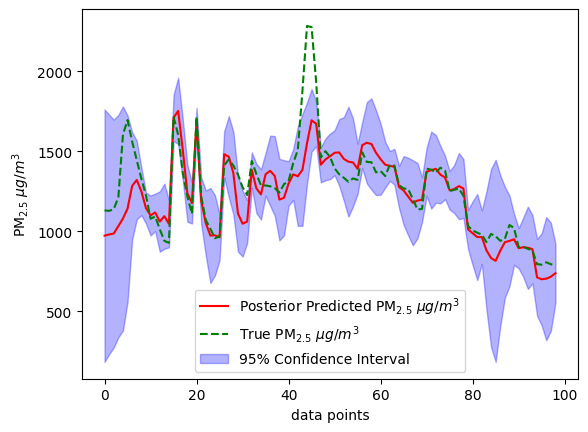

In [167]:
plt.plot(np.arange(len(y_pred)), y_pred, label='Posterior Predicted PM$_{2.5}$ $\mu g/m^3$', color='r')
plt.plot(np.arange(len(y_pred)), Y_test, label='True PM$_{2.5}$ $\mu g/m^3$', color='g', linestyle='--')
# plt.scatter(np.arange(len(y_pred)), Y_test, label='True PM$_{2.5}$ $\mu g/m^3$', color='g', marker='x')
# plt.scatter(np.arange(len(y_pred)), y_pred, label='Posterior Predicted PM$_{2.5}$ $\mu g/m^3$', color='r',marker='x')
plt.fill_between(np.arange(len(y_pred)), y_lower, y_upper, alpha=0.3, color='b', label='95% Confidence Interval')
# Scatter plot with error bars
# plt.errorbar(np.arange(len(y_pred)), y_pred, yerr=1.96*y_std, fmt='o', color='r', ecolor='k', capsize=3, capthick=1)

plt.xlabel('data points')
plt.ylabel('PM$_{2.5}$ $\mu g/m^3$')
plt.legend()

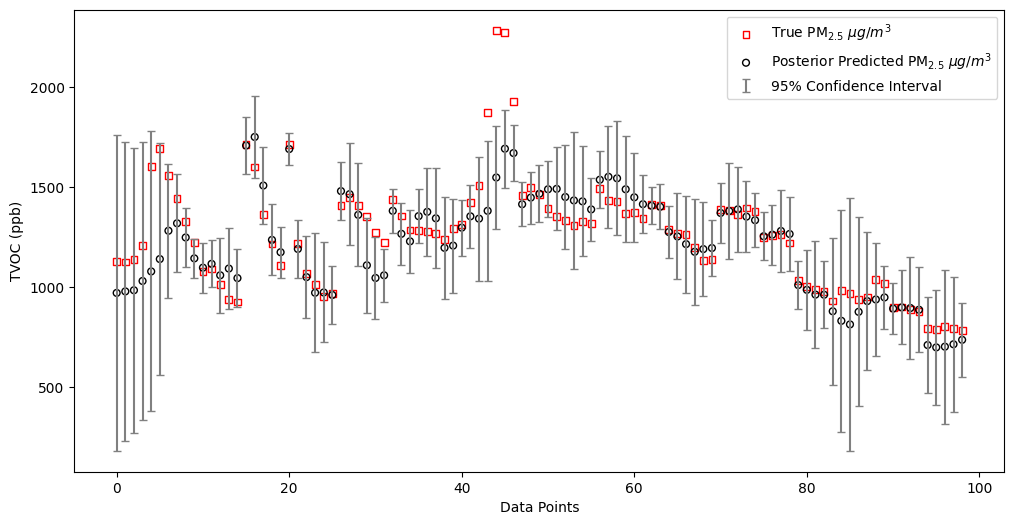

In [168]:
plt.figure(figsize=(12, 6))
# True values as smaller squares with only borders (hollow squares)
plt.scatter(np.arange(len(Y_test)), Y_test, label='True PM$_{2.5}$ $\mu g/m^3$', edgecolor='red', facecolor='none', marker='s', s=24)

# Predicted values as smaller circles with only borders (hollow circles)
plt.scatter(np.arange(len(y_pred)), y_pred, label='Posterior Predicted PM$_{2.5}$ $\mu g/m^3$', edgecolor='black', facecolor='none', marker='o', s=24)

# Error bars to represent confidence interval
plt.errorbar(np.arange(len(y_pred)), y_pred, yerr=1.96*y_std, fmt='none', ecolor='gray', capsize=3, label='95% Confidence Interval')

plt.xlabel('Data Points')
plt.ylabel('TVOC (ppb)')
plt.legend()
plt.show()

In [169]:
def evaluate(y_true, y_pred, print_metrics=False):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    nmse = mean_squared_error(y_true, y_pred) / (np.mean(y_true) * np.mean(y_pred))
    correlation = np.corrcoef(np.asarray(y_true, dtype=float), np.asarray(y_pred, dtype=float))[0, 1]
    if print_metrics:
        print('Correlation: {:.2f}'.format(correlation))
        print('NMSE: {:.2f}'.format(nmse))
        print('RMSE: {:.2f}'.format(rmse))
        print('MAE: {:.2f}'.format(mae))
        print('R2: {:.2f}'.format(r2))
    return correlation, nmse, rmse, mae, r2

In [170]:
def factioanl_error(y_true, y_pred, print_metrics=False):
    fb = 2 * (np.mean(y_pred) - np.mean(y_true)) / (np.mean(y_true) + np.mean(y_pred))
    fs = 2 * (np.var(y_pred) - np.var(y_true)) / (np.var(y_true) + np.var(y_pred))
    if print_metrics:
        print('Fractional Bias: {:.2f}'.format(fb))
        print('Fractional Spread: {:.2f}'.format(fs))
    return fb, fs

In [171]:
def plot_regression_line(y_pred, y_true, model_name = 'GPR', iaq = 'TVOC'):
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)
    model = LinearRegression().fit(y_pred, y_true)
    intercept = model.intercept_

    plt.figure()
    plt.scatter(y_pred, y_true, color='blue')

    y_pred_line = np.linspace(np.min(y_pred), np.max(y_pred), len(y_pred), dtype='float64')
    y_rol = model.predict(y_pred_line.reshape(-1, 1))
    # Plot the slope 1.25 and slope 0.75 lines
    plt.plot(y_pred_line, y_rol, color='red', linewidth=2)
    plt.plot(y_pred_line, 1.25*y_pred_line + (y_rol[0] - 1.25*y_pred_line[0]), color='green', linestyle='-', zorder=1)
    plt.plot(y_pred_line, 0.75*y_pred_line + (y_rol[0] - 0.75*y_pred_line[0]), color='green', linestyle='-', zorder=1)

    plt.fill_between(y_pred_line, 
                     0.75*y_pred_line + (y_rol[0] - 0.75*y_pred_line[0]), 
                     1.25*y_pred_line + (y_rol[0] - 1.25*y_pred_line[0]), color='green', alpha=0.2, label='Accepatable Slope Range')

    plt.axhline(y=intercept, color='orange', linestyle='--', label='Intercept Line')
    plt.axhspan(ymin=-0.25*np.mean(y_true), ymax=0.25*np.mean(y_true), color='magenta', alpha=0.3, label='25% Mean of Mesurements')
    
    if iaq == 'TVOC':
        plt.xlabel('Predicted TVOC (ppb)')
        plt.ylabel('True TVOC (ppb)')
        plt.title(f'{model_name} TVOC Regression Line')
    elif iaq == 'PM2.5':
        plt.xlabel('Predicted PM2.5 (ug/m3)')
        plt.ylabel('True PM2.5 (ug/m3)')
        plt.title(f'{model_name} PM2.5 Regression Line')
    plt.legend()
    # plt.margins(0)  # Reduce margins
    plt.tight_layout()

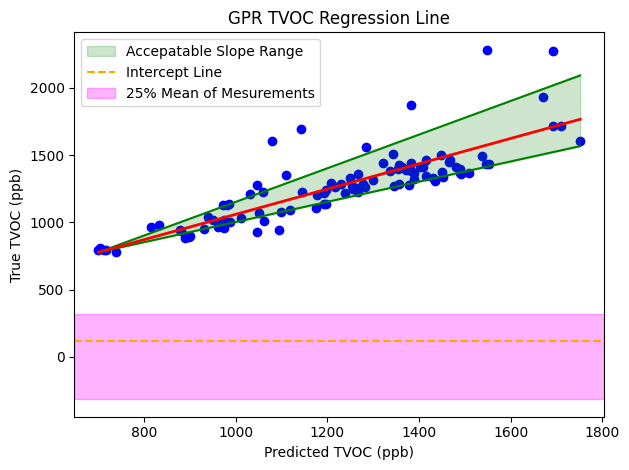

In [172]:
plot_regression_line(y_pred, Y_test, model_name='GPR', iaq=iaq_type)

In [173]:
# Initialize the KNN model
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model on the training data
knn.fit(xyt_scaled, Y_train)

# Make predictions on the test set
knn_predictions = knn.predict(xyt_test_scaled)

evaluate(Y_test, knn_predictions)

(0.6565900159573231,
 0.02824261780689251,
 212.58533521264994,
 147.2959595959596,
 0.42308933753931643)

In [174]:
# Initialize the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(xyt_scaled, Y_train)

# Make predictions on the test set
rf_predictions = rf.predict(xyt_test_scaled)

evaluate(Y_test, rf_predictions)

(0.7542474319529309,
 0.0222176705086155,
 186.04409640274304,
 109.4660101010101,
 0.5581511306425979)

In [175]:
# Initialize the SVM model
svm = SVR(kernel='rbf', C=100.0, epsilon=0.1)

# Fit the model on the training data
svm.fit(xyt_scaled, Y_train)

# Make predictions on the test set
svm_predictions = svm.predict(xyt_test_scaled)

# Evaluate the SVM model
evaluate(Y_test, svm_predictions)

(0.589846500670242,
 0.036815227874838485,
 236.57734500461027,
 155.9767023925317,
 0.28552297443602226)

reconstraining parameters Mat32.lengthscale


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s08  0002   4.095805e+06   7.505290e+12 
    00s19  0005   1.211941e+06   2.152079e+11 
    01s19  0030   1.808098e+03   2.384227e+02 
    03s25  0076   1.562760e+03   8.073714e-01 
    04s08  0097   1.562686e+03   3.640333e-07 
Runtime:     04s08
Optimization status: Converged

Fractional Bias: -0.02
Fractional Spread: -0.02
Fractional Bias: 0.05
Fractional Spread: -0.11
Fractional Bias: 0.03
Fractional Spread: -0.32
Fractional Bias: 0.02
Fractional Spread: -0.70


reconstraining parameters Mat32.lengthscale


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s17  0005   1.164335e+06   2.029692e+11 
    01s20  0036   1.509261e+03   1.300855e-01 
    02s14  0061   1.502336e+03   3.074485e-07 
Runtime:     02s14
Optimization status: Converged

Fractional Bias: 0.04
Fractional Spread: -0.02
Fractional Bias: 0.01
Fractional Spread: -0.99


reconstraining parameters Mat32.lengthscale


Fractional Bias: 0.02
Fractional Spread: -0.21
Fractional Bias: -0.03
Fractional Spread: -1.15
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s18  0007   5.111102e+05   1.745914e+10 
    01s18  0046   1.450478e+03   1.564123e-02 
    02s15  0083   1.445773e+03   9.751551e-07 
Runtime:     02s15
Optimization status: Converged

Fractional Bias: 0.03
Fractional Spread: -0.08
Fractional Bias: 0.05
Fractional Spread: -1.05
Fractional Bias: 0.00
Fractional Spread: -0.32


reconstraining parameters Mat32.lengthscale


Fractional Bias: 0.02
Fractional Spread: -1.02
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s18  0006   6.000469e+05   4.340721e+10 
    02s19  0086   1.334275e+03   4.486134e+00 
    02s55  0101   1.332878e+03   8.661907e-08 
Runtime:     02s55
Optimization status: Converged

Fractional Bias: 0.01
Fractional Spread: -0.46
Fractional Bias: 0.00
Fractional Spread: -1.02
Fractional Bias: -0.02
Fractional Spread: -0.50
Fractional Bias: -0.05
Fractional Spread: -1.32


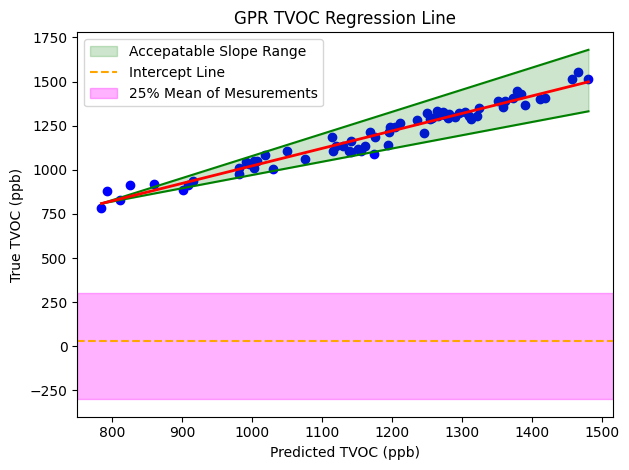

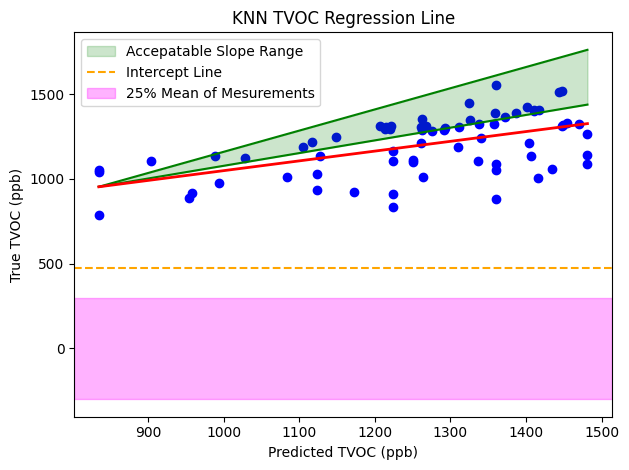

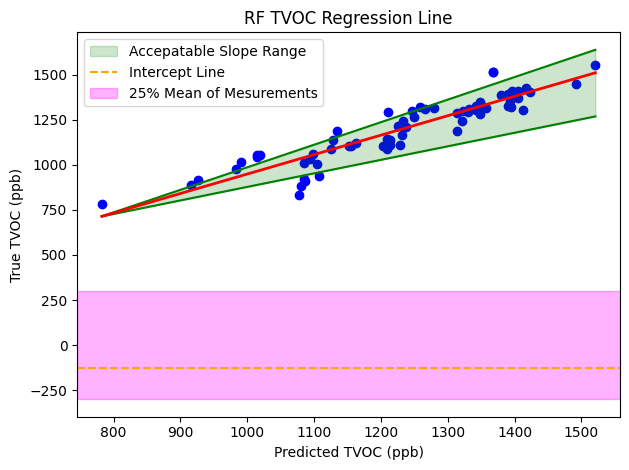

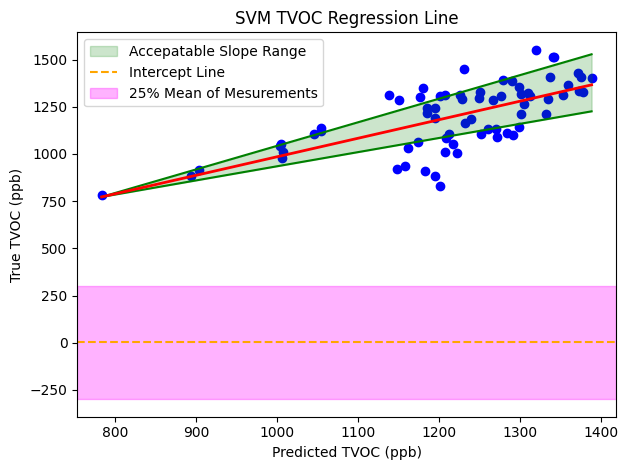

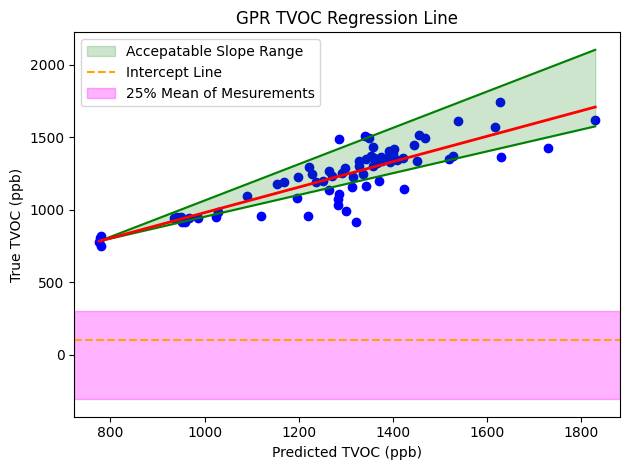

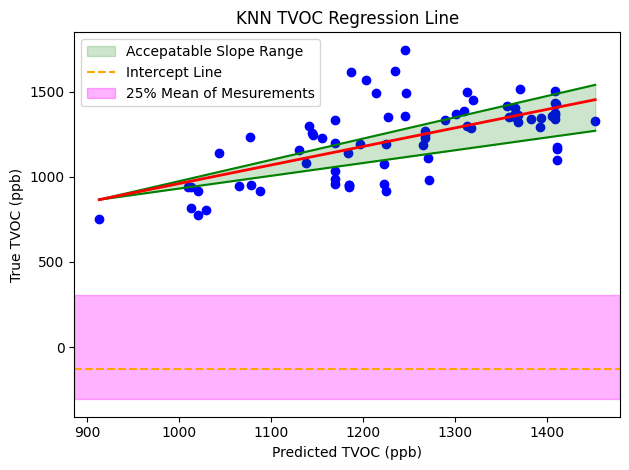

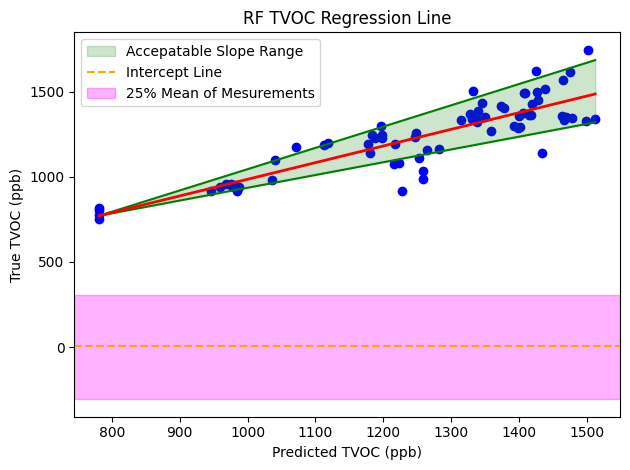

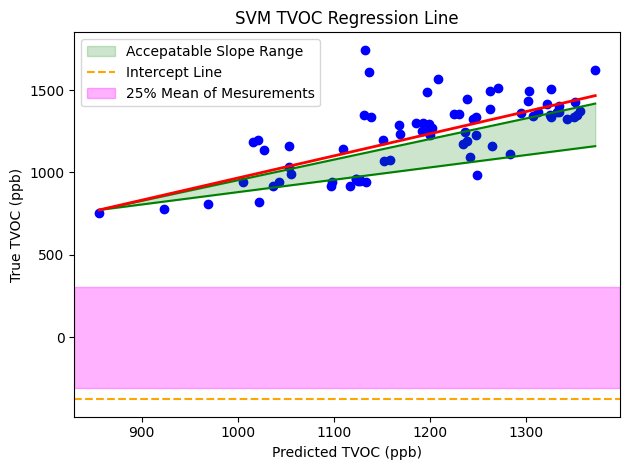

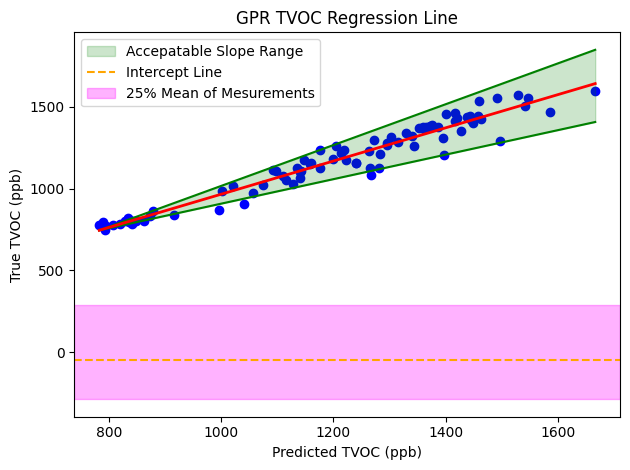

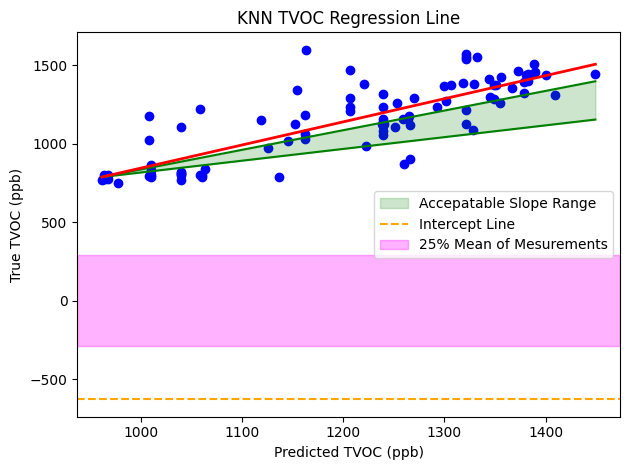

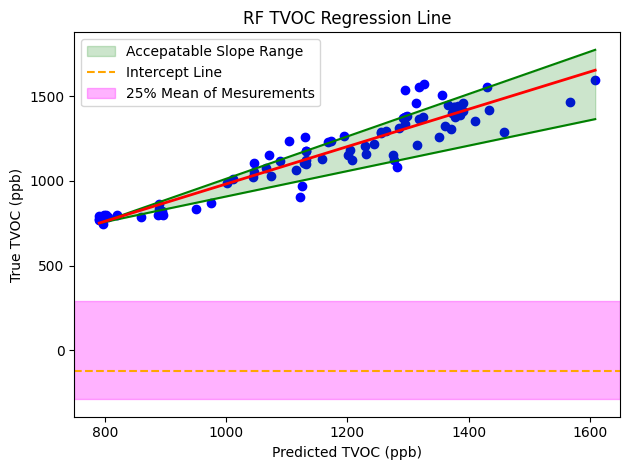

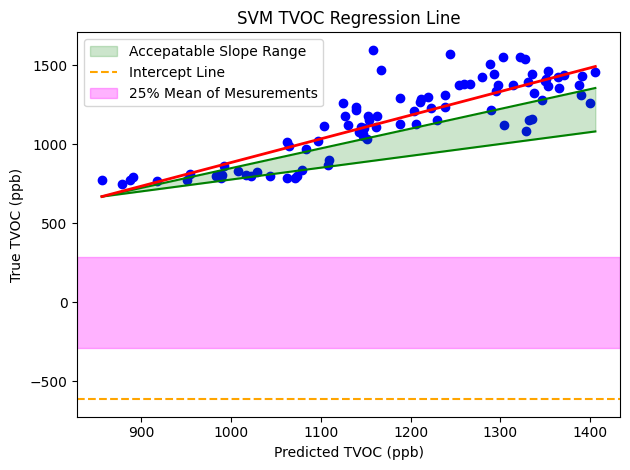

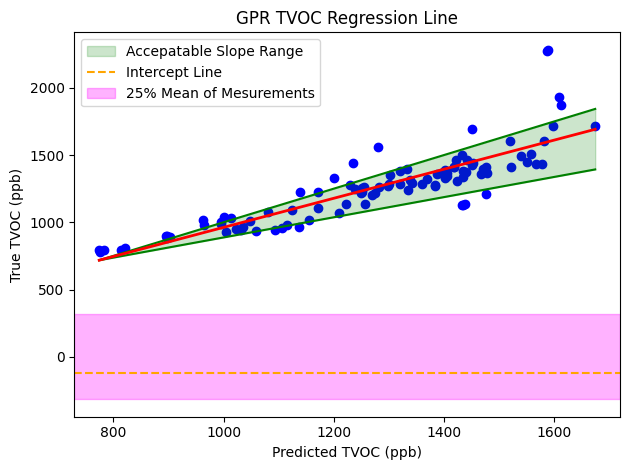

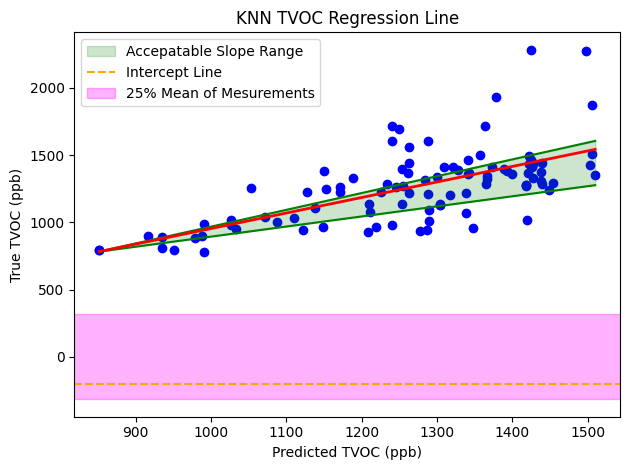

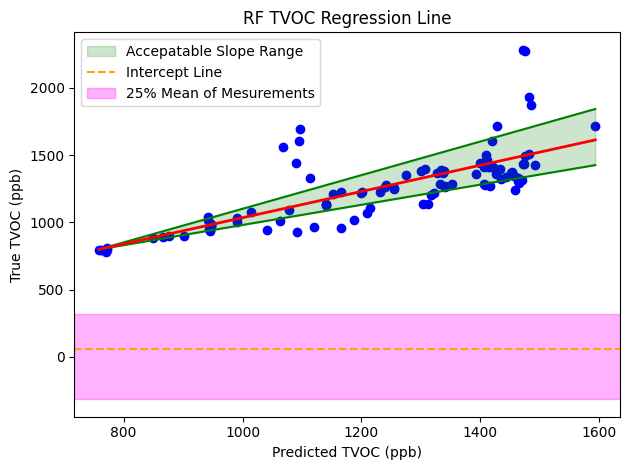

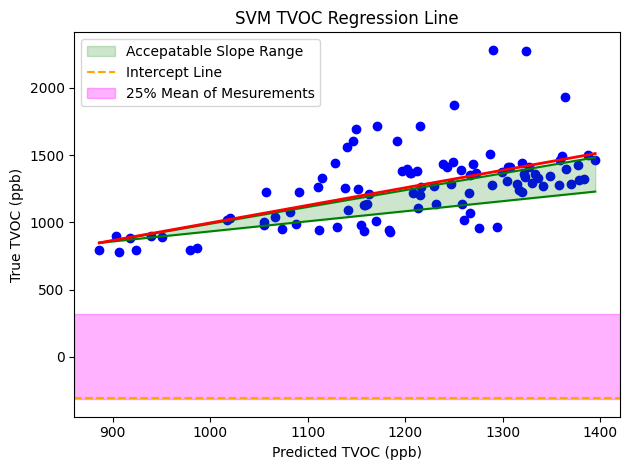

In [176]:
reduction = [0.2, 0.3, 0.4, 0.5]
models = ['GPR', 'KNN', 'RF', 'SVM']

split_data = split_by_area(xyt, Y)

correlations = np.zeros((len(split_data['xyt_train']), len(split_data['xyt_train'])))
nmses = np.zeros((len(split_data['xyt_train']), len(split_data['xyt_train'])))
rmses = np.zeros((len(split_data['xyt_train']), len(split_data['xyt_train'])))
maes = np.zeros((len(split_data['xyt_train']), len(split_data['xyt_train'])))
r2s = np.zeros((len(split_data['xyt_train']), len(split_data['xyt_train'])))
fbs = np.zeros((len(split_data['xyt_train']), len(split_data['xyt_train'])))
fss = np.zeros((len(split_data['xyt_train']), len(split_data['xyt_train'])))

for i in range(len(split_data['xyt_train'])):
    xyt_train = split_data['xyt_train'][i]
    Y_train = split_data['Y_train'][i]
    xyt_test = split_data['xyt_test'][i]
    Y_test = split_data['Y_test'][i]
    scaler = StandardScaler().fit(xyt_train)
    xyt_scaled = scaler.transform(xyt_train)
    xyt_test_scaled = scaler.transform(xyt_test)

    gpr = gp_train(xyt_scaled, Y_train)
    y_pred, y_var = gpr.predict(xyt_test_scaled)
    
    plot_regression_line(y_pred, Y_test, iaq=iaq_type)
    plt.savefig(f'figure/spatial_{iaq_type}_area_{i}_{models[0]}.png')
    correlations[i,0], nmses[i,0], rmses[i,0], maes[i,0], r2s[i,0]= evaluate(Y_test.flatten(), y_pred.flatten())
    fbs[i,0], fss[i,0] = factioanl_error(Y_test.flatten(), y_pred.flatten(), print_metrics=True)

    # Initialize the KNN model
    knn = KNeighborsRegressor(n_neighbors=5)
    # Fit the model on the training data
    knn.fit(xyt_scaled, Y_train)
    # Make predictions on the test set
    knn_predictions = knn.predict(xyt_test_scaled)

    plot_regression_line(knn_predictions, Y_test, model_name=models[1], iaq=iaq_type)
    plt.savefig(f'figure/spatial_{iaq_type}_area_{i}_{models[1]}.png')
    correlations[i,1], nmses[i,1], rmses[i,1], maes[i,1], r2s[i,1] = evaluate(Y_test, knn_predictions)
    fbs[i,1], fss[i,1] = factioanl_error(Y_test.flatten(), knn_predictions.flatten(), print_metrics=True)

    # Initialize the Random Forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    # Fit the model on the training data
    rf.fit(xyt_scaled, Y_train)
    # Make predictions on the test set
    rf_predictions = rf.predict(xyt_test_scaled)

    plot_regression_line(rf_predictions, Y_test, model_name=models[2],  iaq=iaq_type)
    plt.savefig(f'figure/spatial_{iaq_type}_area_{i}_{models[2]}.png')
    correlations[i,2], nmses[i,2], rmses[i,2], maes[i,2], r2s[i,2] = evaluate(Y_test, rf_predictions)
    fbs[i,2], fss[i,2] = factioanl_error(Y_test.flatten(), rf_predictions.flatten(), print_metrics=True)
    
    # Initialize the SVM model
    svr = SVR(kernel='rbf', C=100.0, epsilon=0.1)
    # Fit the model on the training data
    svr.fit(xyt_scaled, Y_train)
    # Make predictions on the test set
    svr_predictions = svr.predict(xyt_test_scaled) 
    
    plot_regression_line(svr_predictions, Y_test, model_name=models[3], iaq=iaq_type)
    plt.savefig(f'figure/spatial_{iaq_type}_area_{i}_{models[3]}.png')
    correlations[i,3], nmses[i,3], rmses[i,3], maes[i,3], r2s[i,3] = evaluate(Y_test, svr_predictions)
    fbs[i,3], fss[i,3] = factioanl_error(Y_test.flatten(), svr_predictions.flatten(), print_metrics=True)

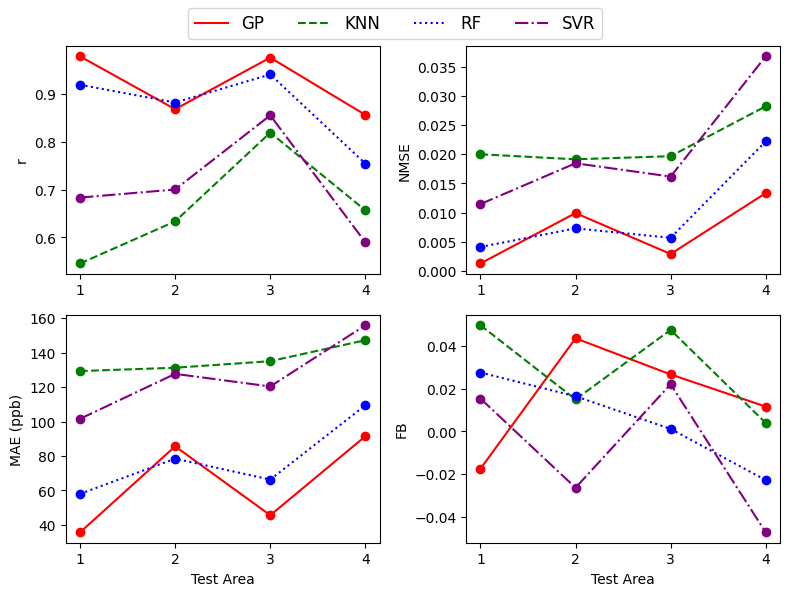

In [177]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))  # Create a 2x2 grid of subplots

# Titles for clarity
if iaq_type == 'TVOC':
    titles = ['r', 'NMSE', 'MAE (ppb)', 'FB']
elif iaq_type == 'PM2.5':
    titles = ['r', 'NMSE', 'MAE ($\mu g/m^3$)', 'FB']
data = [correlations, nmses, maes, fbs]
labels = ['GP', 'KNN', 'RF', 'SVR']
colors = ['red', 'green', 'blue', 'purple']  # Colors for each model
line_styles = ['-', '--', ':', '-.']  # Different line styles for each model

# Iterate over the range of metrics and plot each in its subplot
for i in range(4):
    ax = axs[i//2, i%2]  # Determine the position of the current subplot
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['1', '2', '3', '4'])
    ax.set_xlabel('Area')
    for j in range(4):
        ax.plot(data[i][:, j], label=labels[j], color=colors[j], linestyle=line_styles[j], marker='o')
    if i//2 == 0:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Test Area')
    ax.set_ylabel(titles[i])
    # ax.grid(True)  # Optional: Add grid for better readability

# Create a single legend for all subplots
lines = [plt.Line2D([0], [0], color=color, linestyle=style) for color, style in zip(colors, line_styles)]
fig.legend(lines, labels, loc='upper center', ncol=4, frameon=True, fontsize='large')

fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend above
plt.savefig(f'figure/spatial_{iaq_type}_metrics.png')


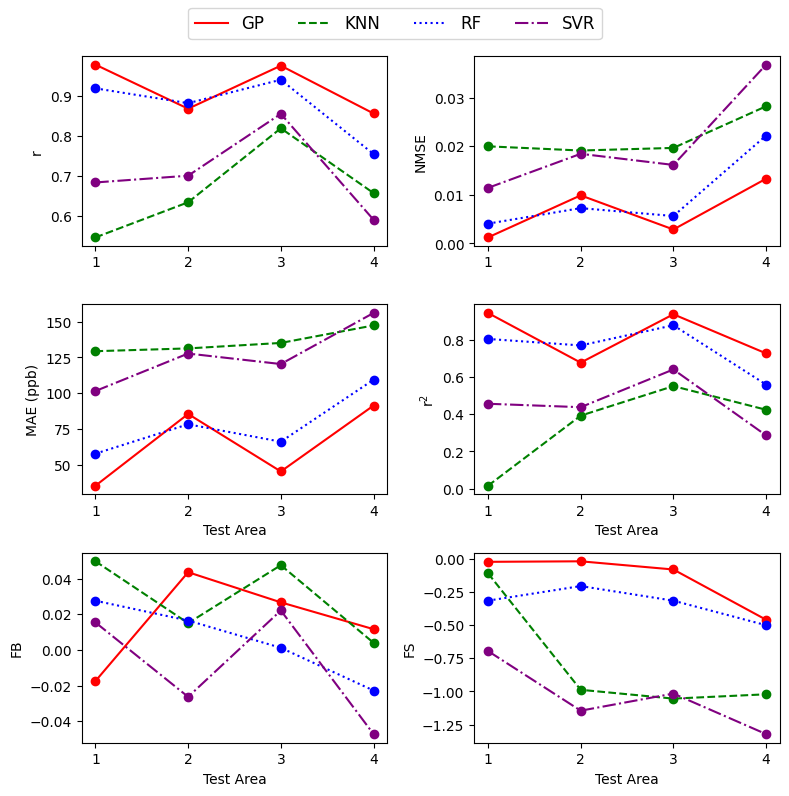

In [178]:
fig, axs = plt.subplots(3, 2, figsize=(8, 8))  # Create a 2x2 grid of subplots

# Titles for clarity
if iaq_type == 'TVOC':
    titles = ['r', 'NMSE', 'MAE (ppb)', 'r$^2$','FB', 'FS']
elif iaq_type == 'PM2.5':
    titles = ['r', 'NMSE', 'MAE ($\mu g/m^3$)', 'r$^2$','FB', 'FS']
data = [correlations, nmses, maes, r2s, fbs, fss]
labels = ['GP', 'KNN', 'RF', 'SVR']
colors = ['red', 'green', 'blue', 'purple']  # Colors for each model
line_styles = ['-', '--', ':', '-.']  # Different line styles for each model

# Iterate over the range of metrics and plot each in its subplot
for i in range(6):
    ax = axs[i//2, i%2]  # Determine the position of the current subplot
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['1', '2', '3', '4'])
    ax.set_xlabel('Area')
    for j in range(4):
        ax.plot(data[i][:, j], label=labels[j], color=colors[j], linestyle=line_styles[j], marker='o')
    if i//2 == 0:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Test Area')
    ax.set_ylabel(titles[i])
    # ax.grid(True)  # Optional: Add grid for better readability

# Create a single legend for all subplots
lines = [plt.Line2D([0], [0], color=color, linestyle=style) for color, style in zip(colors, line_styles)]
fig.legend(lines, labels, loc='upper center', ncol=4, frameon=True, fontsize='large')

fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend above
plt.savefig(f'figure/spatial_{iaq_type}_metrics_extended.png')


In [179]:
# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'Area': ['1', '2', '3', '4'],
    'GPR_Correlation': correlations[:, 0],
    'GPR_NMSE': nmses[:, 0],
    'GPR_MAE': maes[:, 0],
    'GPR_FB': fbs[:, 0],
    'GPR_FS': fss[:, 0],
    'GPR_R2': r2s[:, 0],
    'KNN_Correlation': correlations[:, 1],
    'KNN_NMSE': nmses[:, 1],
    'KNN_MAE': maes[:, 1],
    'KNN_FB': fbs[:, 1],
    'KNN_FS': fss[:, 1],
    'KNN_R2': r2s[:, 1],
    'RF_Correlation': correlations[:, 2],
    'RF_NMSE': nmses[:, 2],
    'RF_MAE': maes[:, 2],
    'RF_FB': fbs[:, 2],
    'RF_FS': fss[:, 2],
    'RF_R2': r2s[:, 2],
    'SVM_Correlation': correlations[:, 3],
    'SVM_NMSE': nmses[:, 3],
    'SVM_MAE': maes[:, 3],
    'SVM_FB': fbs[:, 3],
    'SVM_FS': fss[:, 3],
    'SVM_R2': r2s[:, 3]
})

# Print the DataFrame in a tabulated format
metrics_df.to_csv(f'figure/spatial_{iaq_type}_metrics.csv')